In [2]:
from matplotlib import pyplot as plt

from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer

import numpy as np

import scipy.sparse as sp

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import explained_variance_score, r2_score

from time import perf_counter

from utils import perm_W, perm_H

In [3]:
# parameters
SOLVER = "cd" # NMF solver
INIT = "nndsvda" # initialization method
MAX_ITER = 1000 # number of iterations in the NMF
N_TOP_WORDS = 10 # number of words to display for each topic
RANDOM_STATE = 0 # for reproducability

In [4]:
# download relevant nltk datasets
download("wordnet")
download("omw-1.4")
download("punkt")
download("averaged_perceptron_tagger")

[nltk_data] Downloading package wordnet to /home/max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/max/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/max/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/max/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# load dataset
dataset = fetch_20newsgroups(
    shuffle=True,
    random_state=RANDOM_STATE,
    remove=("headers", "footers", "quotes"),
)

n_topics = len(dataset.target_names)

In [6]:
# preprocess data
lemmatizer = WordNetLemmatizer()
def preprocess(text: str) -> str:
    tokens = word_tokenize(text.lower())
    cleaned = [token for token in tokens if token.isalpha()]
    nouns = [word for (word, pos) in pos_tag(cleaned) if pos in ("NN", "NNS", "NNP")]
    lemmatized = [lemmatizer.lemmatize(noun, pos="n") for noun in nouns]
    return " ".join(lemmatized)

data = [preprocess(doc) for doc in dataset.data]

### Create term frequency matrix of data

In [7]:
# vectorize the documents using term frequency * inverse document frequency
vectorizer = TfidfVectorizer(stop_words="english", use_idf=False)
freq_matrix = vectorizer.fit_transform(data)

In [8]:
# construct actual factorization for error calculation

# one-hot encoding for weights
W_true_oh = sp.csr_matrix((dataset.target.size, n_topics))
for i in range(W_true_oh.shape[0]):
    W_true_oh[i, dataset.target[i]] = 1

# topic documents to get topic term frequencies
topic_docs = [" ".join([doc for i, doc in enumerate(data) if j == dataset.target[i]]) for j in range(n_topics)]
vectorizer = TfidfVectorizer(stop_words="english")
H_true_td = vectorizer.fit_transform(topic_docs)

# least squares solution of factorization
H_true_oh = sp.linalg.inv(W_true_oh.T @ W_true_oh) @ W_true_oh.T @ freq_matrix
W_true_td = (sp.linalg.inv(H_true_td @ H_true_td.T) @ H_true_td @ freq_matrix.T).T

# reconstruction
X_true_oh = W_true_oh @ H_true_oh
X_true_td = W_true_td @ H_true_td

/home/max/Repos/Data-Science-Seminar/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/max/Repos/Data-Science-Seminar/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/max/Repos/Data-Science-Seminar/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [9]:
X_true_oh

<11314x37467 sparse matrix of type '<class 'numpy.float64'>'
	with 50930945 stored elements in Compressed Sparse Row format>

In [12]:
(W_true_oh.T @ W_true_oh).shape

(20, 20)

In [10]:
X_true_td

<11314x37467 sparse matrix of type '<class 'numpy.float64'>'
	with 409814046 stored elements in Compressed Sparse Column format>

In [16]:
# reconstruction difference
print(np.linalg.norm(X_true_oh - X_true_td))

# reconstruction error
print(np.linalg.norm(X_true_oh - freq_matrix))
print(np.linalg.norm(X_true_td - freq_matrix))

# difference
print(np.linalg.norm(H_true_oh - H_true_td))
print(np.linalg.norm(W_true_oh - W_true_td))

: 

: 

In [ ]:
explained_variance_score(X_oh, X_td)

: 

: 

In [ ]:
def diff(Y_true, Y_pred) -> float:
    return np.linalg.norm(Y_true - Y_pred, axis=1).mean()

def recon_error(X_true, X_pred) -> float:
    return np.linalg.norm(X_true - X_pred)

def accuracy(W_pred) -> float:
    return np.sum(np.argmax(W_pred, axis=1) == dataset.target) / len(dataset.target)

def explained_variance(X_true, X_pred) -> float:
    

In [ ]:
# norm over topics
norms = np.linalg.norm(H_true_oh - H_true_td, axis=0)
print(norms.min())
print(norms.mean())
print(norms.max())
print(norms.std())

1.4067173100906858e-07
0.0066155849780913005
0.8725312413618992
0.018959165649307386


In [ ]:
print(norms)

[0.01111386 0.03606985 0.00180376 ... 0.00047148 0.00103416 0.00212007]


In [ ]:
# norm over terms
norms = np.linalg.norm(H_true_oh - H_true_td, axis=1)
print(norms.min())
print(norms.mean())
print(norms.max())
print(norms.std())

0.8225680916601698
0.8686188019150295
0.9704569167585207
0.029426744315867018


In [ ]:
print(norms)

[0.87717364 0.87294567 0.97045692 0.83372931 0.84762502 0.86932731
 0.863232   0.85349138 0.87345129 0.86368701 0.85050381 0.83923755
 0.89748958 0.88035749 0.87864249 0.82256809 0.85423384 0.86418714
 0.88328732 0.87674918]


In [ ]:
np.linalg.norm(W_true_oh, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

### Extraction of the 20 Topics

In [ ]:
# use NMF to decompose the document vectors into topic vectors
nmf = NMF(n_components=n_topics, solver=SOLVER, init=INIT, random_state=RANDOM_STATE, max_iter=MAX_ITER)
W = nmf.fit_transform(freq_matrix) # weights
H = nmf.components_ # hidden variables

In [ ]:
# print the topics with their most occuring words
for i in range(n_topics):
    top_indices = H[i].argsort()[:-N_TOP_WORDS-1:-1]
    top_words = vectorizer.get_feature_names_out()[top_indices]
    print(f"Topic {i}:", *top_words)

Topic 0: god jesus life christian word faith christ belief religion truth
Topic 1: problem error solution monitor machine line screen apple idea memory
Topic 2: year team lot league season player month money model guy
Topic 3: thanks advance hi info anybody help reply information response email
Topic 4: drive disk controller scsi computer mac tape power cable hd
Topic 5: time week bit day life bike course month minute idea
Topic 6: information book list lot group space day software source article
Topic 7: people person world life lot group reason armenian point post
Topic 8: thing sort lot course bike idea point kind bit fact
Topic 9: card driver video monitor color mode bus port slot memory
Topic 10: chip key encryption clipper phone bit government algorithm escrow data
Topic 11: car price driver engine bike mile dealer model speed power
Topic 12: window driver application version manager font memory screen server mouse
Topic 13: file directory format image disk help site ftp copy pc


In [ ]:
pred = nmf.inverse_transform(W)
tru = freq_matrix.todense()
print(r2_score(tru, pred))
print(explained_variance_score(tru, pred))

/home/max/Repos/Data-Science-Seminar/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


: 

: 

In [ ]:
def score(y_true, y_pred):
    y_diff_avg = (y_true - y_pred).mean(0)
    numerator = ((y_true - y_pred - y_diff_avg) ** 2).mean(0)
    y_true_avg = y_true.mean(0)
    denominator = ((y_true - y_true_avg) ** 2).mean(0)
    return (1 - numerator / denominator).mean()

In [ ]:
score(freq_matrix, nmf.inverse_transform(W))

: 

: 

### Solver comparison

In [ ]:
def score(model, data):
    pred = model.inverse_transform(model.transform(data))
    return explained_variance_score(data, pred)

In [ ]:
solvers = ["cd", "mu"]
for i, solver in enumerate(solvers):
    nmf = NMF(n_components=n_topics, solver=solver, init=INIT, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    t0 = perf_counter()
    weights = nmf.fit_transform(freq_matrix)
    H = nmf.components_
    t = perf_counter()
    time = t - t0
    top_words = [[]] * n_topics
    for i in range(n_topics):
        top_words_idx = H[i].argsort()[:-N_TOP_WORDS-1:-1]
        top_words[i] = [vectorizer.get_feature_names_out()[j] for j in top_words_idx]

    print(f"Solver '{solver}':")
    print(f"runtime = {time} seconds")
    print(f"reconstruction error = {nmf.reconstruction_err_}")
    print(f"tfidf error = {error(H)}")
    print(f"accuracy = {accuracy(weights)}", end="\n\n")


Solver 'cd':
runtime = 2.3287573080160655 seconds
reconstruction error = 1179.568869283379
tfidf error = 86.38783584082277
accuracy = 0.06461021742973308

Solver 'mu':
runtime = 11.101368566974998 seconds
reconstruction error = 1180.1657794978644
tfidf error = 83.64724718899461
accuracy = 0.06646632490719463



### Initialization comparison

In [ ]:
inits = ["random", "nndsvd", "nndsvda", "nndsvdar"]
for i, init in enumerate(inits):
    nmf = NMF(n_components=N_TOPICS, solver=SOLVER, init=init, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    nmf.fit_transform(doc_vectors)
    print(f"reconstruction error for '{init}': {nmf.reconstruction_err_}")

reconstruction error for 'random': 101.37013310805062
reconstruction error for 'nndsvd': 101.34793376680442
reconstruction error for 'nndsvda': 101.34793505032103
reconstruction error for 'nndsvdar': 101.3479350876765


### Comparison of different ranks

In [ ]:
ranks = np.arange(1, 26)
errors = np.zeros(len(ranks))
for i, rank in enumerate(ranks):
    print(f"Calculating rank {rank:2} approximation...", end=" ")
    nmf = NMF(n_components=rank, solver=SOLVER, init=init, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    nmf.fit_transform(doc_vectors)
    errors[i] = nmf.reconstruction_err_
    print("done.")

Calculating rank  1 approximation...done.
Calculating rank  2 approximation...done.
Calculating rank  3 approximation...done.
Calculating rank  4 approximation...done.
Calculating rank  5 approximation...done.
Calculating rank  6 approximation...done.
Calculating rank  7 approximation...done.
Calculating rank  8 approximation...done.
Calculating rank  9 approximation...done.
Calculating rank 10 approximation...done.
Calculating rank 11 approximation...done.
Calculating rank 12 approximation...done.
Calculating rank 13 approximation...done.
Calculating rank 14 approximation...done.
Calculating rank 15 approximation...done.
Calculating rank 16 approximation...done.
Calculating rank 17 approximation...done.
Calculating rank 18 approximation...done.
Calculating rank 19 approximation...done.
Calculating rank 20 approximation...done.
Calculating rank 21 approximation...done.
Calculating rank 22 approximation...done.
Calculating rank 23 approximation...done.
Calculating rank 24 approximation.

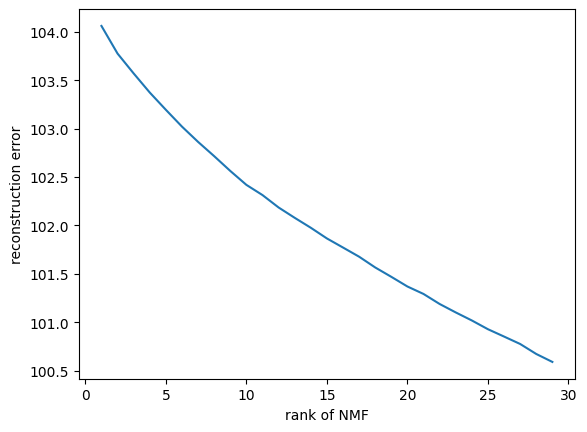

In [ ]:
plt.plot(ranks, errors)
plt.xlabel("NMF approximation rank")
plt.ylabel("reconstruction error")
plt.show()